# CVRP HW2 - part 1
In this part, you will explore AutoEncoder (AE) and Variational Auto-Encoder (VAE) on MNIST dataset.
To have faster training efficency, GPU acceleration is recommended. However, don't worry if you reach your GPU usage limit on Colab. This part can still be completed within a reasonable timeframe using a standard CPU.

Some notes:
- This part takes 50 points in total
- We will fix the size of latent code vector to be 2 !
- If you made any modifications on the cells with "DO NOT MODIFY" label, please be sure to write a detailed README, otherwise, TA will have a hard time grading your code...
- If you find it's hard to put all the things into a single notebook, you can have additional files. Make sure you have a README as well.
- Please zip all the notebooks or files you have to a compressed zip file before submission.

In [1]:
# NOTE: DO NOT MODIFY
# Import neccessary packages
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import pdb

# Decide which driver to use
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device used : {device}")

Device used : cuda


### MNIST dataset loader
Please do not modify this cell

In [2]:
# NOTE: DO NOT MODIFY
tensor_transform = transforms.ToTensor()

batch_size = 256
MNIST_dataset = datasets.MNIST(root = "./data",
							train = True,
							download = True,
							transform = tensor_transform)

MNIST_loader = torch.utils.data.DataLoader(dataset = MNIST_dataset,
										batch_size = batch_size,
										shuffle = True)


### Visualization functions
1. `plot_latent_images` will sample a vector with size 2 (same as $z$), feed into the decoder and plot out the decoded image
2. `plot_z` plots the distribution of $z$. Since $z$ has size 2, we can map it to a 2D plot and see the ddistribution of each class
3. `eval` visualizes the difference between the original images and reconstruncted images

In [3]:
def plot_latent_images(model, n, digit_size=28):
    grid_x = np.linspace(-1, 1, n)
    grid_y = np.linspace(-1, 1, n)

    image_width = digit_size * n
    image_height = digit_size * n
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
            with torch.no_grad():
                x_decoded = model.decode(z)
            digit = x_decoded.view(digit_size, digit_size).cpu().numpy()
            image[i * digit_size: (i + 1) * digit_size,
                  j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()


def plot_z(dataloader, model):
    batch_progress = dataloader
    latent_z = []
    all_labels = []
    for iter, (images, labels) in enumerate(batch_progress):
        batch_size = images.shape[0]
        images = images.reshape(batch_size, -1).to(device)
        output = model(images)
        encoded = output["z"]
        #print(encoded)
        latent_z.extend(list(encoded.detach().cpu()))
        all_labels.extend(list(labels.detach().cpu()))

    latent_z = np.array(latent_z)
    all_labels = np.array(all_labels)
    # plot 2D
    plt.figure(figsize=(10, 10))
    for label in range(10):
        # Filter points with the current label
        label_points = latent_z[all_labels == label]
        plt.scatter(label_points[:, 0], label_points[:, 1], label=f"Label {label}")

    plt.title("2D Plot of latent variable")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.legend()
    plt.show()


def eval(model):
    original_imgs = torch.cat([MNIST_dataset[i][0] for i in range(5)])
    with torch.no_grad():
      res = model(original_imgs.reshape(5, -1).to(device))
      reconstructed_imgs = res['imgs']
      reconstructed_imgs = reconstructed_imgs.cpu().reshape(*original_imgs.shape)

    fig, axes = plt.subplots(5, 2, figsize=(10, 25))

    for i in range(5):
        original_image = original_imgs[i].reshape(28, 28)
        axes[i, 0].imshow(original_image, cmap='gray')
        axes[i, 0].set_title(f'Original Image {i+1}')
        axes[i, 0].axis('off')

        reconstructed_image = reconstructed_imgs[i].reshape(28, 28)
        axes[i, 1].imshow(reconstructed_image, cmap='gray')
        axes[i, 1].set_title(f'Reconstructed Image {i+1}')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


### Training function
If you need to modify it, please make sure you have a README.

In [4]:
def train(dataloader, model, loss_func, optimizer, epochs):
    losses = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        running_loss = 0.0
        for iter, (images, labels) in enumerate(dataloader):
            batch_size = images.shape[0]
            images = images.reshape(batch_size, -1).to(device)
            loss = loss_func(model, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            avg_loss = running_loss / len(MNIST_dataset) * batch_size
            losses.append(loss.item())

        tqdm.write(f'Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}')

    return losses


## **AutoEncoder (AE)**
We will start by implementing a simple auto-encoder (AE) and training it on the MNIST dataset.


Tasks:
1. [8 pts] Finish the implementation of `self.encoder` and `self.decoder` in `AE()` model
2. [2 pts] Complete the loss function 
3. Train the AE model on the MNIST dataset (manual tuning of parameters such as epochs, hidden dims, and lr may be necessary). Use the provided evaluation code to visualize the reconstruction results and the generated images (in 2D grid) for the last epoch

In [5]:
class AE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim=2):
        super().__init__()
        
        assert latent_dim == 2, "always use 2 as the latent dimension for generating a 2D image grid during evaluation"
        
        encoder_layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            encoder_layers.extend([
                torch.nn.Linear(prev_dim, hidden_dim),
                torch.nn.ReLU()
            ])
            prev_dim = hidden_dim
        encoder_layers.append(torch.nn.Linear(prev_dim, latent_dim))
        self.encoder = torch.nn.Sequential(*encoder_layers)
        
        decoder_layers = []
        prev_dim = latent_dim
        for hidden_dim in reversed(hidden_dims):
            decoder_layers.extend([
                torch.nn.Linear(prev_dim, hidden_dim),
                torch.nn.ReLU()
            ])
            prev_dim = hidden_dim
        decoder_layers.append(torch.nn.Linear(prev_dim, input_dim))
        decoder_layers.append(torch.nn.Sigmoid())  
        self.decoder = torch.nn.Sequential(*decoder_layers)

    def decode(self, z):
        return self.decoder(z)

    def encode(self, x):
        return self.encoder(x)

    def forward(self, x):
        """
        Return:
            imgs  : decoded image from z
            z     : latent vector
        """
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return {"imgs": decoded,
                "z": encoded}

### Loss Functions
Complete the function `loss_AE` with MSE loss

In [6]:
mse = torch.nn.MSELoss()
def loss_AE(model, x):
    output = model(x)
    reconstructed = output["imgs"]
    return mse(reconstructed, x)

### Optimizers and Training


added code to save models in autoencoder_mnist.pth file

In [7]:
epochs = 50
hidden_dims = [128, 64, 36]
image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()

ae = AE(input_dim, hidden_dims).to(device)

optimizer_ae = torch.optim.Adam(ae.parameters(),
                                lr = 1e-3,
                                weight_decay = 1e-8)

log_ae = train(MNIST_loader, ae, loss_AE, optimizer_ae, epochs)

model_save_path = 'autoencoder_mnist.pth'
torch.save({
    'model_state_dict': ae.state_dict(),
    'optimizer_state_dict': optimizer_ae.state_dict(),
    'epochs': epochs,
    'loss': log_ae,
    'hidden_dims': hidden_dims,
    'input_dim': input_dim
}, model_save_path)

print(f"Model saved to {model_save_path}")

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Average Loss: 0.0296
Epoch [2/50], Average Loss: 0.0205
Epoch [3/50], Average Loss: 0.0192
Epoch [4/50], Average Loss: 0.0184
Epoch [5/50], Average Loss: 0.0175
Epoch [6/50], Average Loss: 0.0169
Epoch [7/50], Average Loss: 0.0164
Epoch [8/50], Average Loss: 0.0161
Epoch [9/50], Average Loss: 0.0159
Epoch [10/50], Average Loss: 0.0157
Epoch [11/50], Average Loss: 0.0155
Epoch [12/50], Average Loss: 0.0153
Epoch [13/50], Average Loss: 0.0152
Epoch [14/50], Average Loss: 0.0151
Epoch [15/50], Average Loss: 0.0150
Epoch [16/50], Average Loss: 0.0149
Epoch [17/50], Average Loss: 0.0148
Epoch [18/50], Average Loss: 0.0147
Epoch [19/50], Average Loss: 0.0147
Epoch [20/50], Average Loss: 0.0146
Epoch [21/50], Average Loss: 0.0145
Epoch [22/50], Average Loss: 0.0144
Epoch [23/50], Average Loss: 0.0144
Epoch [24/50], Average Loss: 0.0143
Epoch [25/50], Average Loss: 0.0143
Epoch [26/50], Average Loss: 0.0143
Epoch [27/50], Average Loss: 0.0142
Epoch [28/50], Average Loss: 0.0141
E

### Evaluation


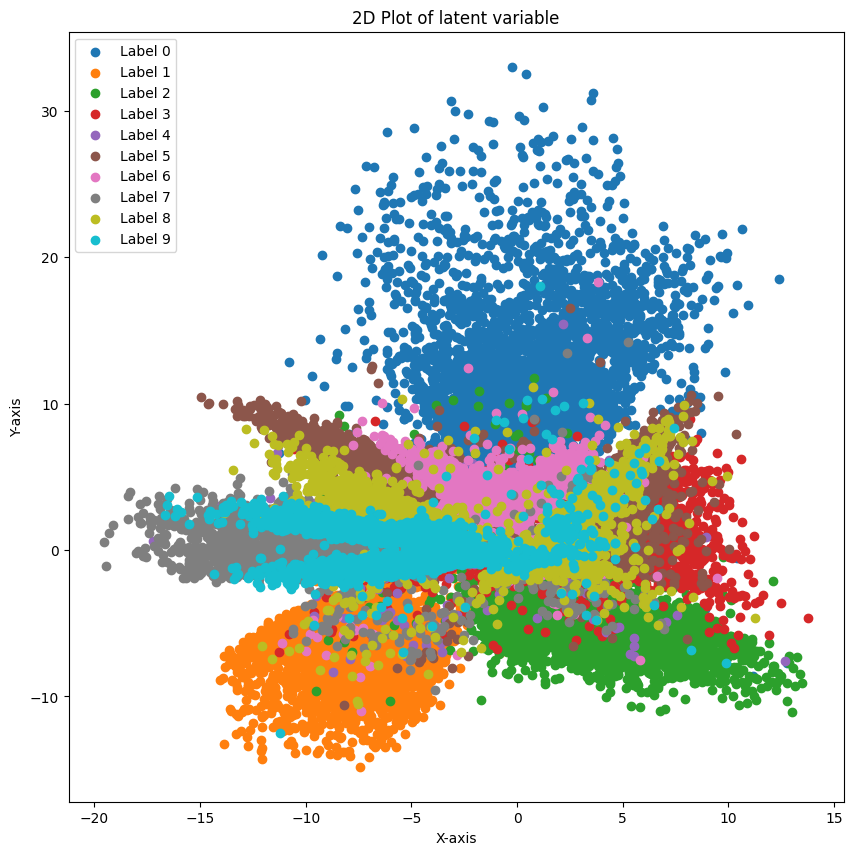

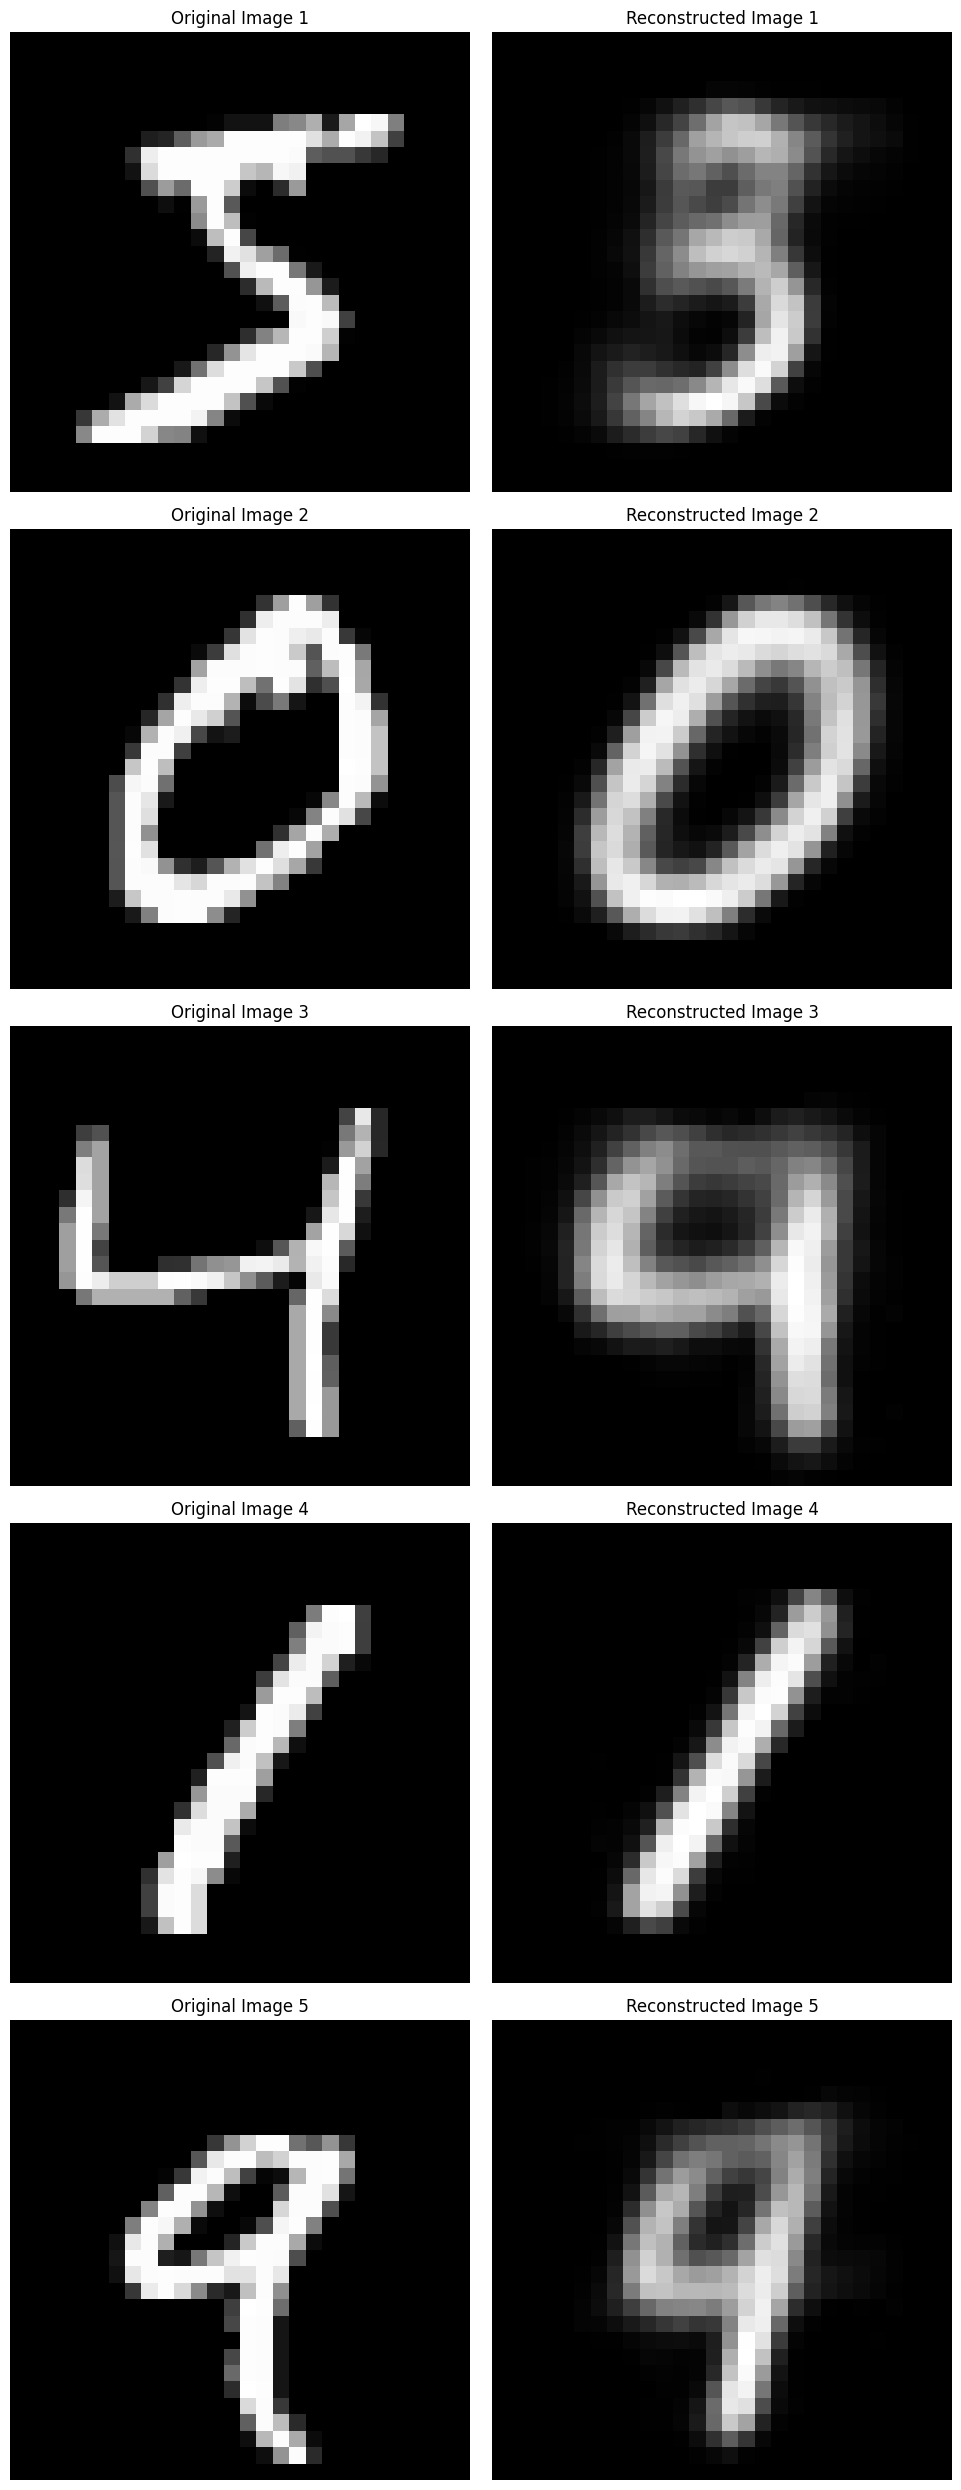

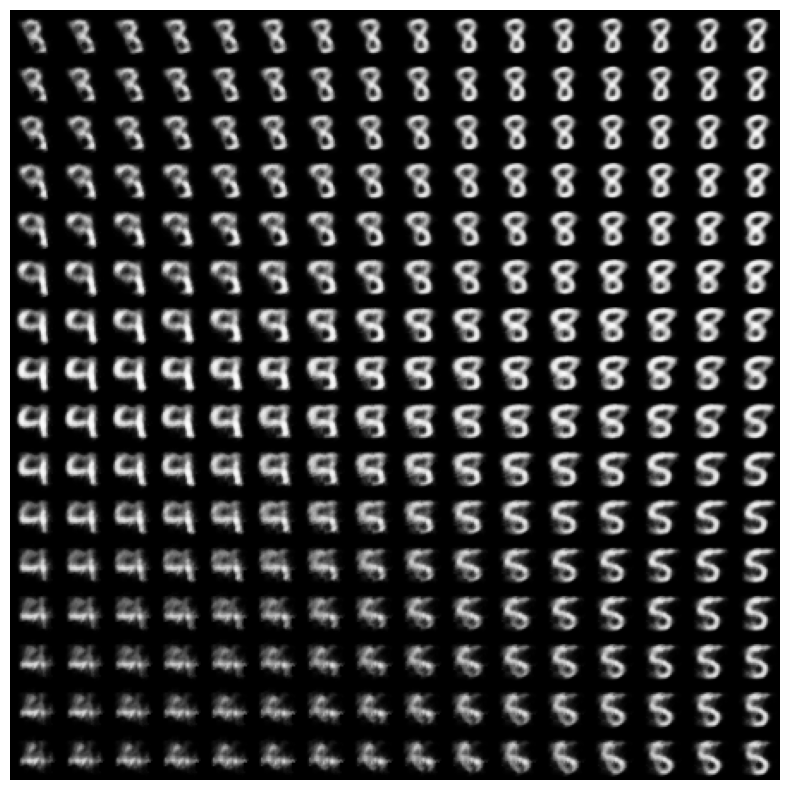

In [8]:
plot_z(MNIST_loader, ae)
eval(ae)
plot_latent_images(ae, n=16)


## **Variational  AutoEncoder (VAE)**
Tasks:

1. [10 pts] Finish the implementation of `self.encoder` and `self.decoder` in `VAE()` model
2. [5 pts] Implement the reparameterization trick in the `reparameterize()` function
2. [5 pts] Complete the loss function 
3. Train the VAE model on the MNIST dataset (manual tuning of parameters such as epochs, hidden dims, and lr may be necessary). Use the provided evaluation code to visualize the reconstruction results and the generated images (in 2D grid) for the last epoch


In [7]:
class VAE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim=2):
        '''
        input_dim: The dimensionality of the input data.
        hidden_dims: A list of hidden dimensions for the layers of the encoder and decoder.
        '''
        super().__init__()

        assert latent_dim == 2, "always use 2 as the latent dimension for generating a 2D image grid during evaluation"
        self.latent_dim = latent_dim

        encoder_layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            encoder_layers.extend([
                torch.nn.Linear(prev_dim, hidden_dim),
                torch.nn.ReLU()
            ])
            prev_dim = hidden_dim
        encoder_layers.append(torch.nn.Linear(prev_dim, 2 * latent_dim))
        self.encoder = torch.nn.Sequential(*encoder_layers)
        
        decoder_layers = []
        prev_dim = latent_dim
        for hidden_dim in reversed(hidden_dims):
            decoder_layers.extend([
                torch.nn.Linear(prev_dim, hidden_dim),
                torch.nn.ReLU()
            ])
            prev_dim = hidden_dim
        decoder_layers.append(torch.nn.Linear(prev_dim, input_dim))
        decoder_layers.append(torch.nn.Sigmoid())
        self.decoder = torch.nn.Sequential(*decoder_layers)

    def encode(self, x):
        mean, logvar = torch.split(self.encoder(x), split_size_or_sections=[self.latent_dim, self.latent_dim], dim=-1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z):
        probs = self.decoder(z)
        return probs

    def forward(self, x, n_samples_per_z=1):
        """
        Return:
            imgs  : decoded image from z
            z     : latent vector
            mean  : mean from encoder
            logvar: logvar from encoder
        """
        mean, logvar = self.encode(x)
        
        z = self.reparameterize(mean, logvar)
        
        decoded = self.decode(z)

        return {
            "imgs": decoded,
            "z": z,
            "mean": mean,
            "logvar": logvar
        }

### Loss Functions
Complete the function `loss_VAE()`

VAE loss = reconstrunction loss (similar to AE) + **coeff** * regularization loss (KL Divergence)


In [8]:
mse = torch.nn.MSELoss()
def loss_VAE(model, x, coeff=1e-4):
    output = model(x)
    reconstructed = output["imgs"]
    mean = output["mean"]
    logvar = output["logvar"]
    
    recon_loss = mse(reconstructed, x)
    
    kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    total_loss = recon_loss + coeff * kl_loss
    
    return total_loss

### Optimizers and Training

In [ ]:
epochs = 50
hidden_dims = [128, 64, 32, 16]

image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()

vae = VAE(input_dim, hidden_dims).to(device)

optimizer_vae = torch.optim.Adam(vae.parameters(),
                                lr = 1e-4,
                                weight_decay = 1e-8)

log_vae = train(MNIST_loader, vae, loss_VAE, optimizer_vae, epochs)

model_save_path = 'vae_mnist.pth'
torch.save({
    'model_state_dict': vae.state_dict(),
    'optimizer_state_dict': optimizer_vae.state_dict(),
    'epochs': epochs,
    'loss': log_vae,
    'hidden_dims': hidden_dims,
    'input_dim': input_dim,
    'latent_dim': 2 
}, model_save_path)

print(f"Model saved to {model_save_path}")

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Average Loss: 0.0666
Epoch [2/50], Average Loss: 0.0272
Epoch [3/50], Average Loss: 0.0257
Epoch [4/50], Average Loss: 0.0255
Epoch [5/50], Average Loss: 0.0255
Epoch [6/50], Average Loss: 0.0254
Epoch [7/50], Average Loss: 0.0254
Epoch [8/50], Average Loss: 0.0253
Epoch [9/50], Average Loss: 0.0253
Epoch [10/50], Average Loss: 0.0253
Epoch [11/50], Average Loss: 0.0253
Epoch [12/50], Average Loss: 0.0253
Epoch [13/50], Average Loss: 0.0253
Epoch [14/50], Average Loss: 0.0253
Epoch [15/50], Average Loss: 0.0253
Epoch [16/50], Average Loss: 0.0253
Epoch [17/50], Average Loss: 0.0253
Epoch [18/50], Average Loss: 0.0253
Epoch [19/50], Average Loss: 0.0253
Epoch [20/50], Average Loss: 0.0253
Epoch [21/50], Average Loss: 0.0253
Epoch [22/50], Average Loss: 0.0253
Epoch [23/50], Average Loss: 0.0253
Epoch [24/50], Average Loss: 0.0253
Epoch [25/50], Average Loss: 0.0253
Epoch [26/50], Average Loss: 0.0253
Epoch [27/50], Average Loss: 0.0253
Epoch [28/50], Average Loss: 0.0253
E

### Evaluation

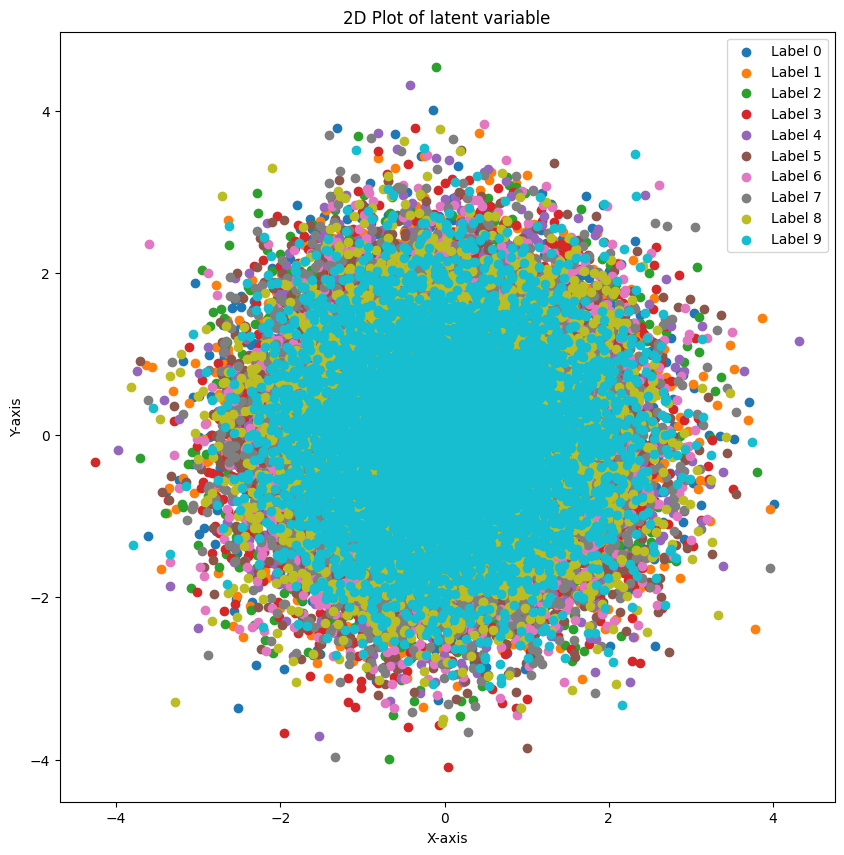

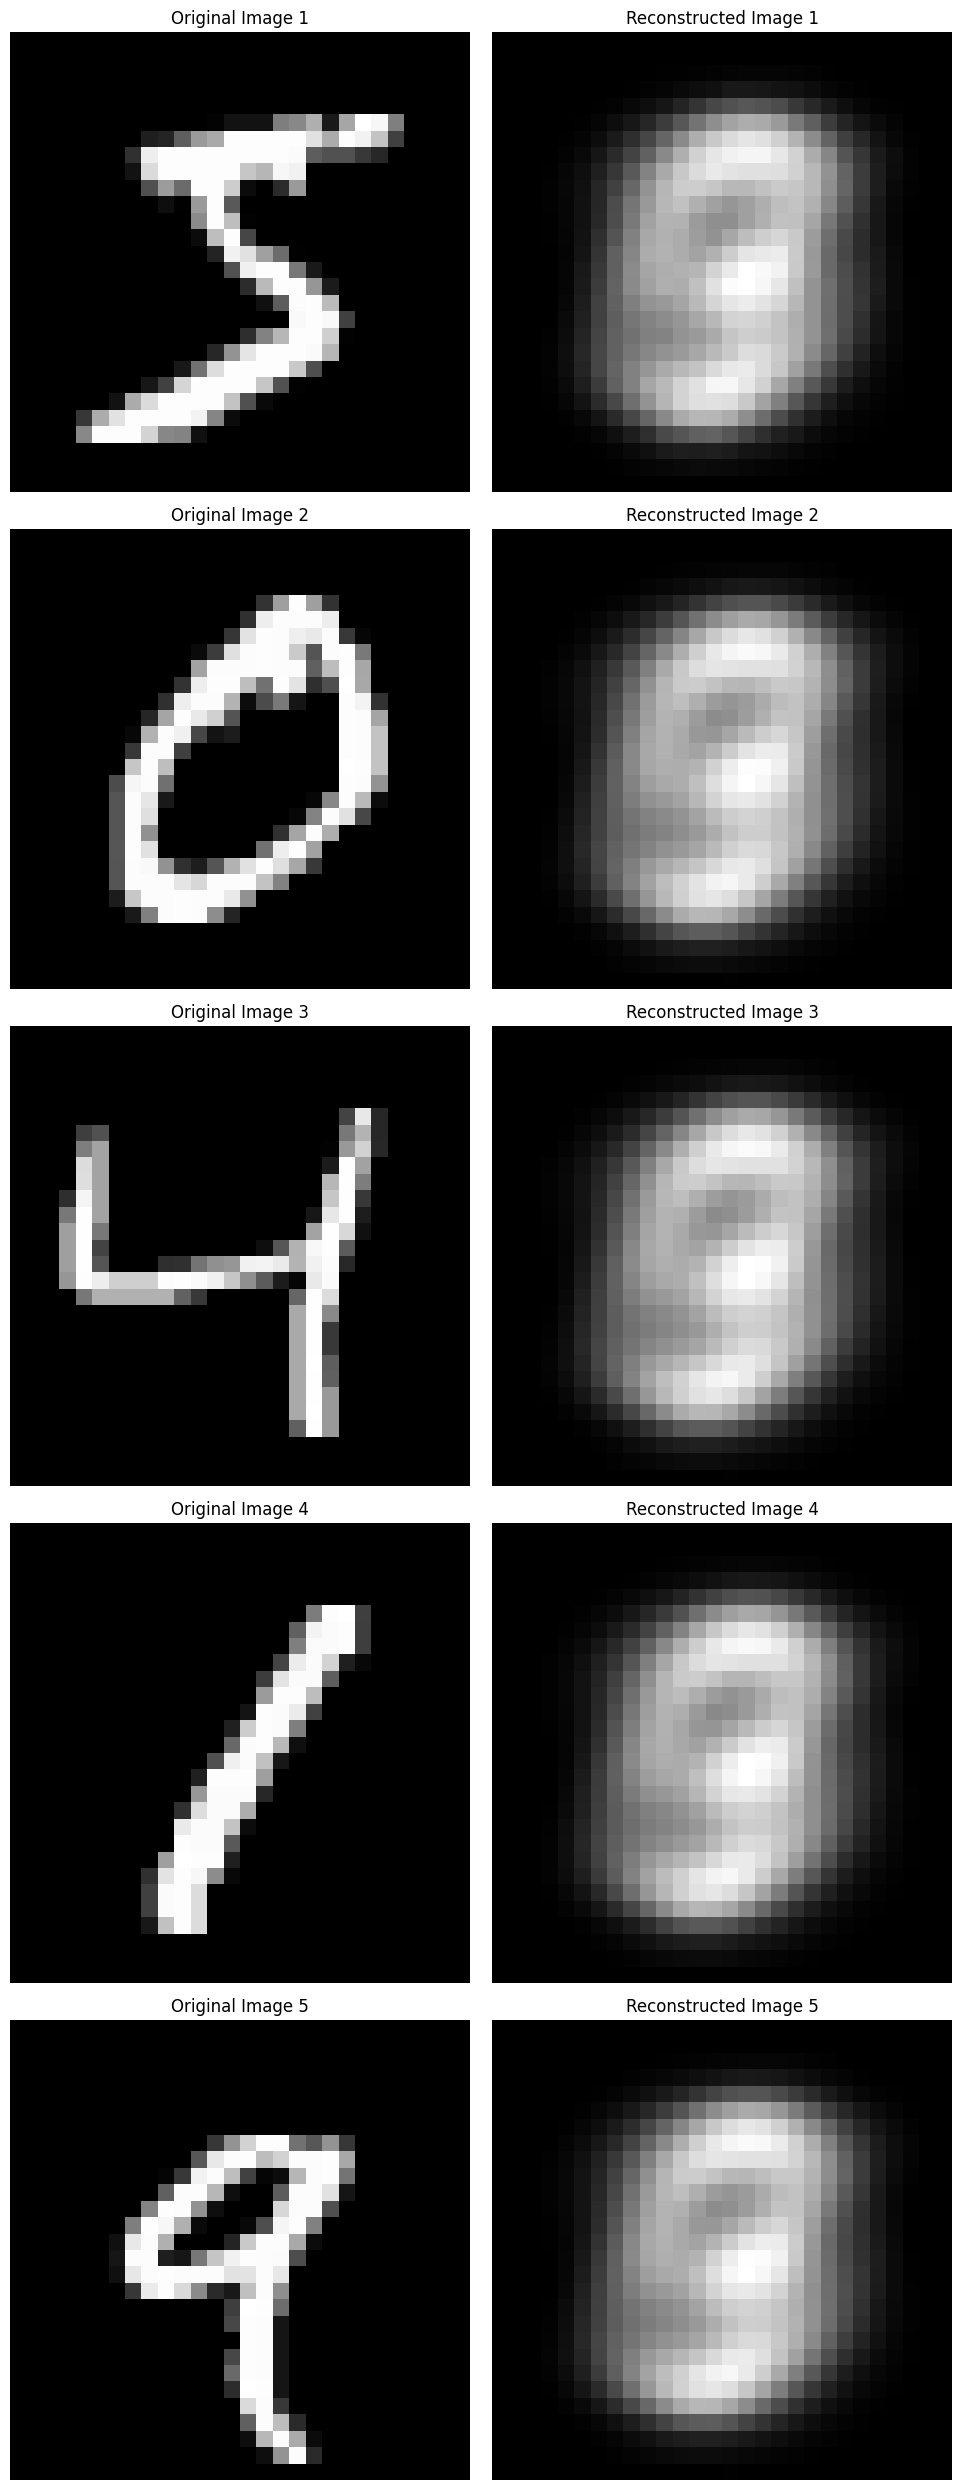

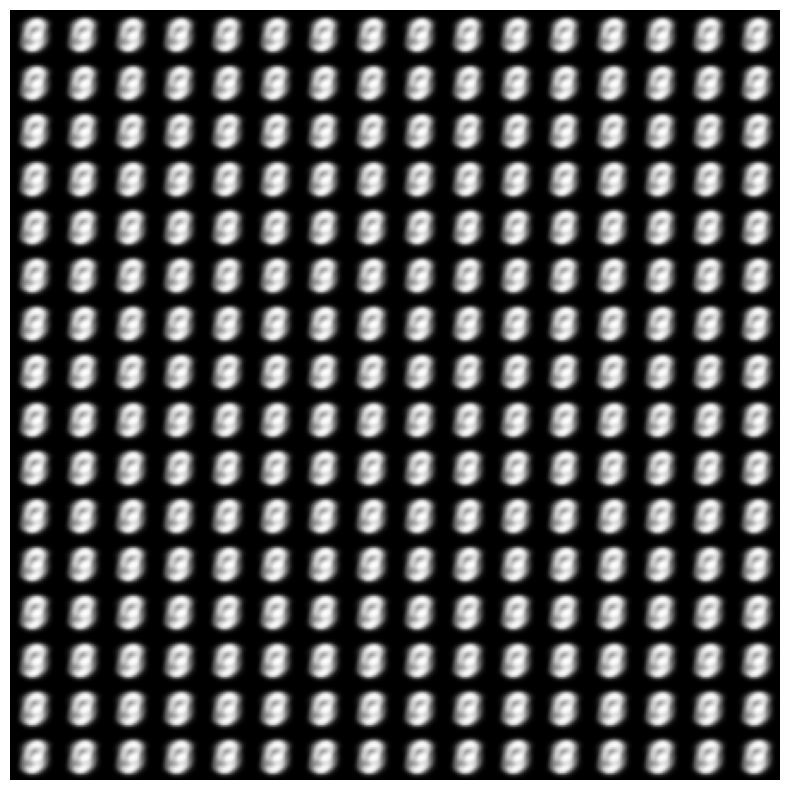

In [ ]:
plot_z(MNIST_loader, vae)
eval(vae)
plot_latent_images(vae, n=16)


## **Questions**
1. [5 pts] In VAEs, remove the KL loss and keep the reconstruction loss only, train the model. Do you observe the std from encoder moves to 0 as we discussed in the class?
2. [10 pts] In VAEs, the regularization term is crucial. Conduct a series of experiments where you adjust this coefficient and observe its impact on reconstruction quality and latent space distribution.
3. [5 pts] After your implementations and experiments, are the generated images from VAE really smoother than from AE? Why?

### Part 1: no KL loss

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Average Loss: 0.0551
Epoch [2/50], Average Loss: 0.0263
Epoch [3/50], Average Loss: 0.0253
Epoch [4/50], Average Loss: 0.0246
Epoch [5/50], Average Loss: 0.0241
Epoch [6/50], Average Loss: 0.0237
Epoch [7/50], Average Loss: 0.0235
Epoch [8/50], Average Loss: 0.0234
Epoch [9/50], Average Loss: 0.0232
Epoch [10/50], Average Loss: 0.0229
Epoch [11/50], Average Loss: 0.0225
Epoch [12/50], Average Loss: 0.0221
Epoch [13/50], Average Loss: 0.0216
Epoch [14/50], Average Loss: 0.0211
Epoch [15/50], Average Loss: 0.0207
Epoch [16/50], Average Loss: 0.0205
Epoch [17/50], Average Loss: 0.0203
Epoch [18/50], Average Loss: 0.0202
Epoch [19/50], Average Loss: 0.0200
Epoch [20/50], Average Loss: 0.0199
Epoch [21/50], Average Loss: 0.0198
Epoch [22/50], Average Loss: 0.0198
Epoch [23/50], Average Loss: 0.0197
Epoch [24/50], Average Loss: 0.0196
Epoch [25/50], Average Loss: 0.0196
Epoch [26/50], Average Loss: 0.0195
Epoch [27/50], Average Loss: 0.0194
Epoch [28/50], Average Loss: 0.0192
E

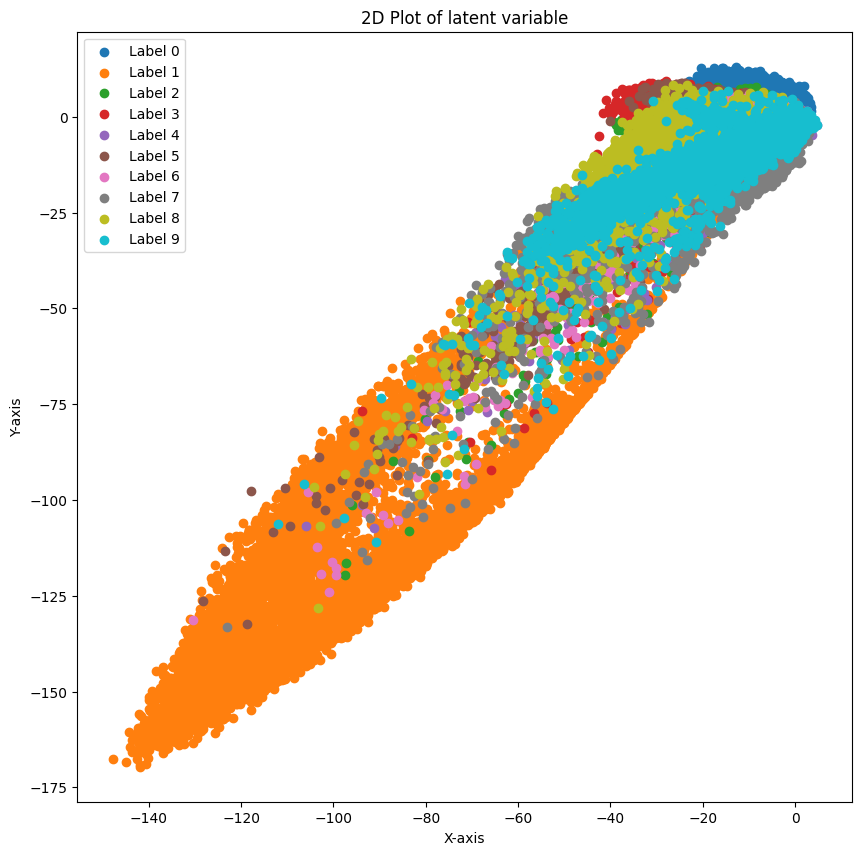

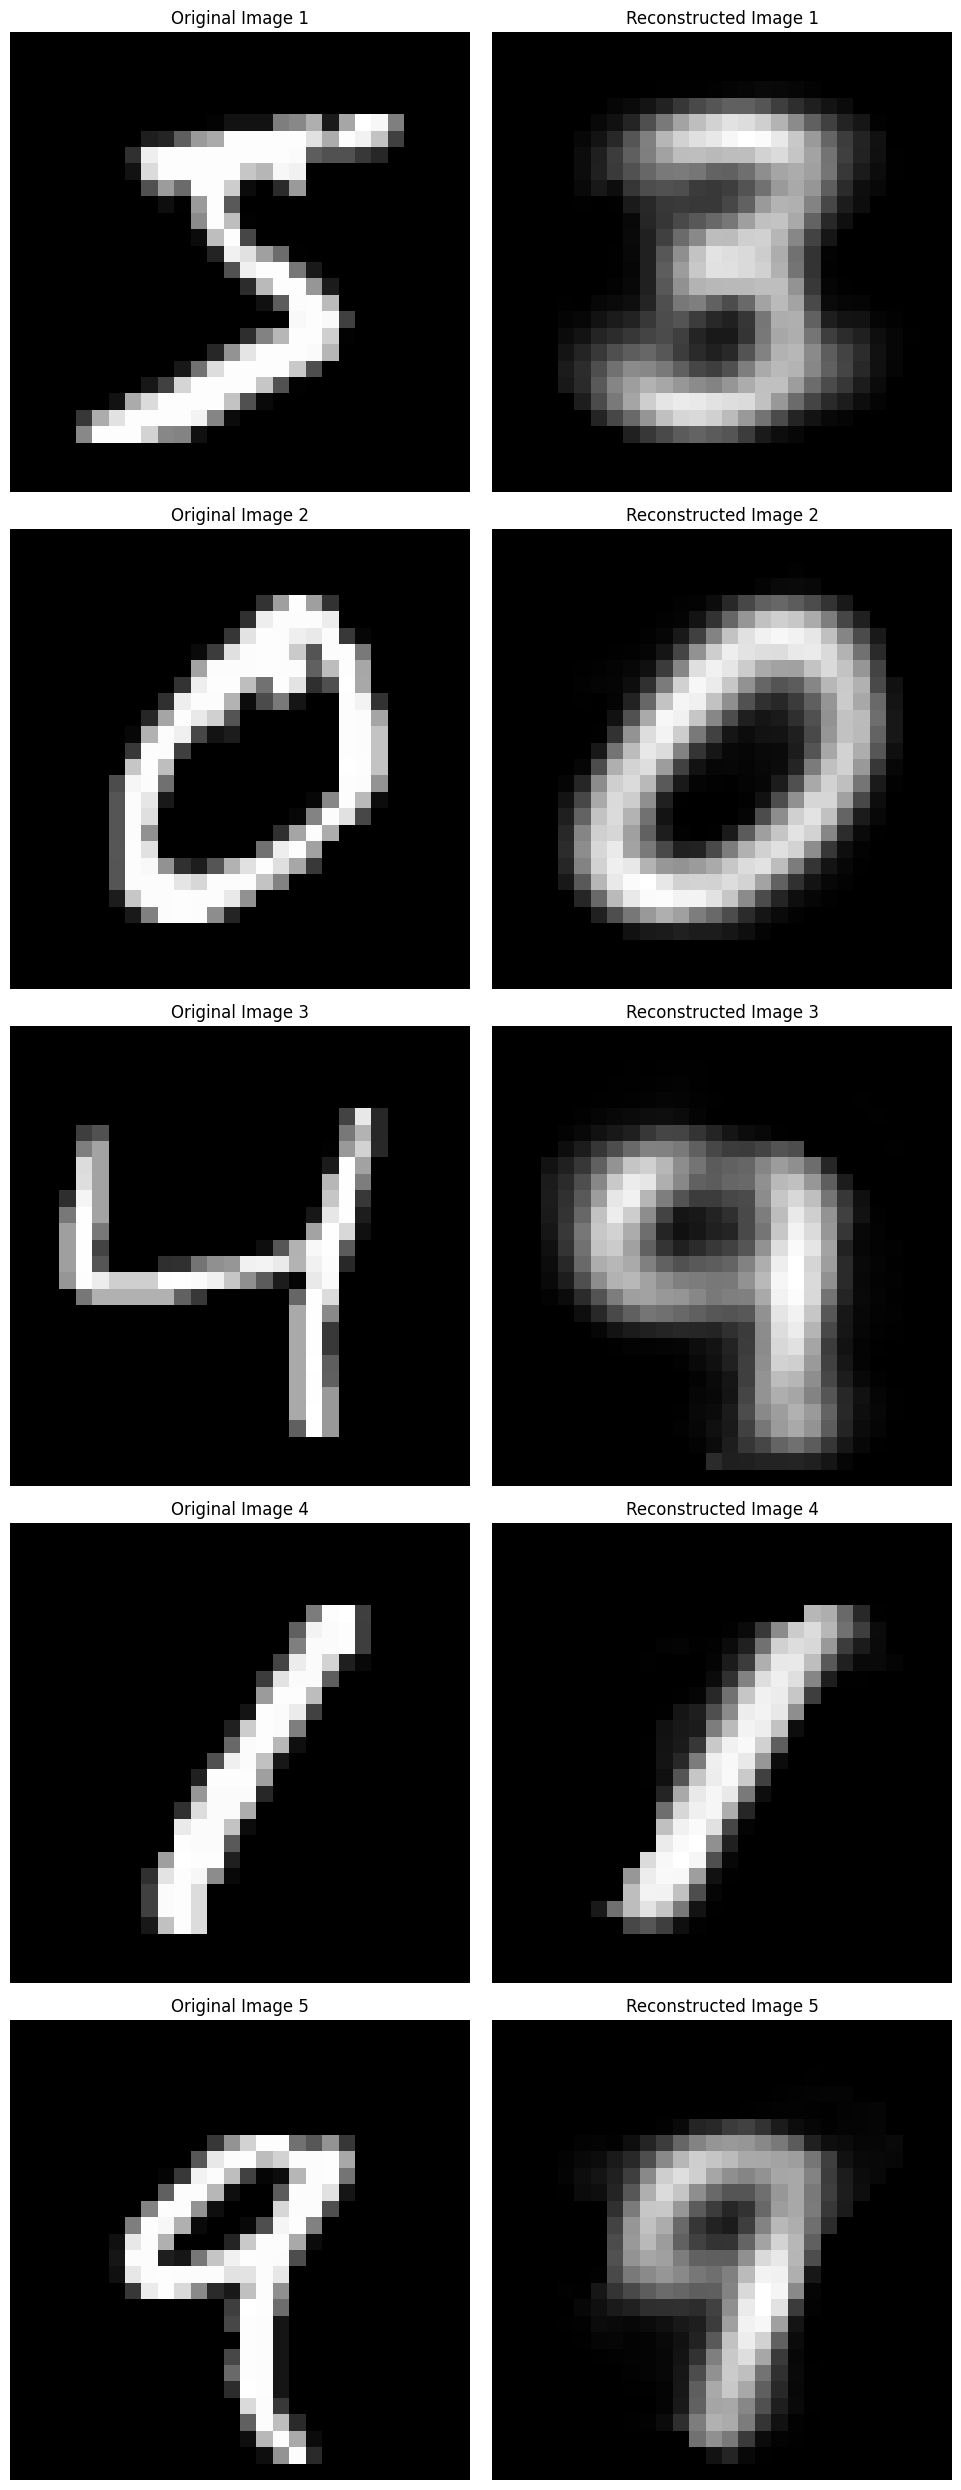

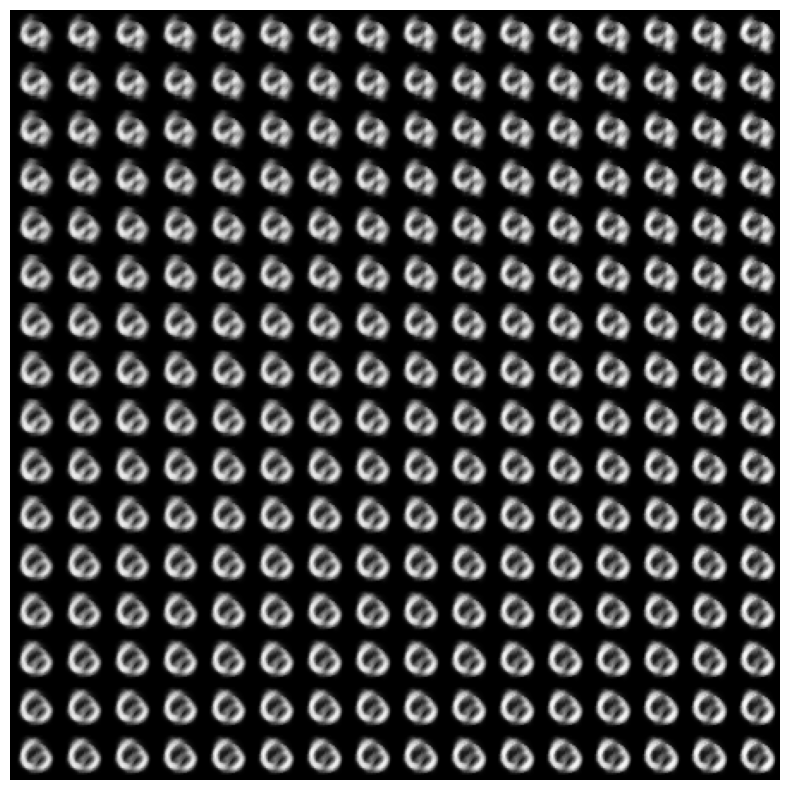

In [ ]:
def loss_VAE_no_KL(model, x):
    output = model(x)
    reconstructed = output["imgs"]
    
    recon_loss = mse(reconstructed, x)
    
    return recon_loss



vae_no_kl = VAE(input_dim, hidden_dims).to(device)

optimizer_vae_no_kl = torch.optim.Adam(vae_no_kl.parameters(),lr=1e-4,weight_decay=1e-8)

log_vae_no_kl = train(MNIST_loader, vae_no_kl, loss_VAE_no_KL, optimizer_vae_no_kl, epochs)
model_save_path = 'vae_no_kl_mnist.pth'
torch.save({
    'model_state_dict': vae_no_kl.state_dict(),
    'optimizer_state_dict': optimizer_vae_no_kl.state_dict(),
    'epochs': epochs,
    'loss': log_vae_no_kl,
    'hidden_dims': hidden_dims,
    'input_dim': input_dim,
    'latent_dim': 2 
}, model_save_path)

print(f"Model saved to {model_save_path}")

plot_z(MNIST_loader, vae_no_kl)
eval(vae_no_kl)
plot_latent_images(vae_no_kl, n=16)



### Part 2: Regularization

In [1]:
kl_coefficients = [1e-6, 1e-4, 1e-2, 1.0, 10.0]
results = {}

for coeff in kl_coefficients:
    print(f"\nTraining VAE with KL coefficient: {coeff}")
   
    vae = VAE(input_dim, hidden_dims).to(device)
    optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4, weight_decay=1e-8)
    
    log = train(MNIST_loader, vae, loss_VAE, optimizer, epochs=50)
    
    model_save_path = f'vae_kl_coeff_{coeff}_mnist.pth'
    torch.save({
        'model_state_dict': vae.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epochs': epochs,
        'loss': log,
        'kl_coefficient': coeff,
        'hidden_dims': hidden_dims,
        'input_dim': input_dim,
        'latent_dim': 2 
    }, model_save_path)
    
    results[coeff] = {
        'model': vae,
        'loss': log
    }
    
    plot_z(MNIST_loader, vae_no_kl)
    eval(vae_no_kl)
    plot_latent_images(vae_no_kl, n=16)


Training VAE with KL coefficient: 1e-06


NameError: name 'VAE' is not defined

In [ ]:
kl_coefficients = [1e-6, 1e-4, 1e-2, 1.0, 10.0]

for idx, coeff in enumerate(kl_coefficients):
    checkpoint = torch.load(f'vae_kl_coeff_{coeff}_mnist.pth')
    model = VAE(checkpoint['input_dim'], checkpoint['hidden_dims']).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    plot_z(MNIST_loader, model)
    eval(model)
    plot_latent_images(model, n=16)

plt.tight_layout()
plt.show()

lost kernel access while replotting, have saved models to share

### Part 3

I felt AE was more smoother